In [111]:
%load_ext autoreload
%autoreload 2
from frozen_lake import *
from climate_control import *
from negotiablegame import NegotiableGame
from pomdplite import POMDPlite
from sparsenoc import SparseNocAlg
from valueIteration import ValueIteration
import numpy as np, numpy.random as nr, gym
from itertools import product
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Seed RNGs so you get the same printouts as me
# env.seed(0)
from gym.spaces import prng; prng.seed(10)

NUM_ITER = 75
GAMMA = 0.95

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
#Only works with gridworld environments
def plot_gridworld(mdp,V, pi, s=None, title=None):
    V = V.reshape(mdp.nrow, mdp.ncol)
    plt.figure(figsize=(3,3))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(mdp.desc[y,x].item().decode()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
    plt.grid(color='b', lw=2, ls='-')
    return

def plot_climate(temps, max_temp, title=None):
    plt.figure(figsize=(7,3))
    if title != None:
        plt.title(title)
    temps = list(temps) + [0] * (6 - len(temps))
    temp_mat = np.array([
        [0,0,temps[1],temps[3],temps[3],temps[5],temps[5]],
        [temps[0],temps[0],temps[1],temps[3],temps[3],temps[5],temps[5]],
        [temps[0],temps[0],temps[2],temps[4],temps[4],temps[4],temps[4]]
    ])
    temp_mat = temp_mat / max_temp
    plt.imshow(temp_mat, cmap='inferno', clim=(0,1)) # 'gist_ncar'
    labels = [(0,1,1),(2,0,2),(2,2,3),(3,0,4),(4,2,5),(5,0,6)]
    for x,y,label in labels:
        plt.text(x, y, str(label), color='g', size=12,  verticalalignment='center',
                 horizontalalignment='center', fontweight='bold')
    return

In [4]:
def run_simulation(algorithm, vis_history=False):
    game = algorithm.game
    s, done = game.reset(), False
    a = algorithm.getFirstAction(s)
    vals = hasattr(algorithm, 'values')
    if vis_history:
        # Add probabilities?
        history = {'rewards':[game.separate_rewards.copy()],
                   'beliefs':[game.b.copy()],
                   'states':[s],
                   'actions':[a],
                   'reward':[game.true_reward],
                   'policies':[algorithm.policy]}
        if vals:
            history['values'] = [algorithm.values]
    while not done:
        sprime, done, p = game.act(a)
        a = algorithm.getNextAction(s,a,sprime)
        s = sprime
        if vis_history:
            history['rewards'] += [game.separate_rewards.copy()]
            history['beliefs'] += [game.b.copy()]
            history['states'] += [s]
            history['actions'] += [a]
            history['reward'] += [game.true_reward]
            history['policies'] += [algorithm.policy]
            if vals:
                history['values'] += [algorithm.values]
    if vis_history:
        return game.discounted_reward, history
    else:
        return game.discounted_reward

In [5]:
# TODO: need to include value returns for all algorithms
def visualize_grid_history(game,history):
    I = len(game.mdps)
    T = len(history['states'])
    for t in range(T):
        V = history['values'][t]
        pol = history['policies'][t]
        s = history['states'][t]
        ws = ' '.join(["B{}: {}".format(i+1, round(history['beliefs'][t][i],3)) for i in range(I)])
        plot_gridworld(game.true_mdp, V, pol, s, title=ws)

In [6]:
def visualize_climate_history(game,history):
    I = len(game.mdps)
    T = len(history['states'])
    history['actions'] += [None]
    for t in range(T):
        rew = ' '.join(["R{}: {}".format(i+1,history['rewards'][t][i]) for i in range(I)])
        ws = ' '.join(["B{}: {}".format(i+1, round(history['beliefs'][t][i],3)) for i in range(I)])
        s, a = history['states'][t], history['actions'][t-1]
        plot_climate(game.true_mdp.s_to_temps(s), game.true_mdp.nT - 1, title= rew + ' ' + ws + ' act: ' + str(a))

In [7]:
def test(alg, n):
    rewards = np.zeros(n)
    for i in range(n):
        rewards[i] = run_simulation(alg)
    print("Mean: " + str(rewards.mean()) + " Std: " + str(rewards.std()))
    return rewards

# Sparse Difference MultiMDP Experiments
## Experiment 1.1: Single (s,a) Difference Gridworld

In [260]:
diffs = np.zeros((64, 4))
diffs[4][2]=1
# diffs[4][1]=1
# diffs[32][3]=1
# diffs[44,3]=1

mdp1 = ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.1, rewards=[1,0])#, map_name="4x4_multigoal")
mdp2 = ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.45, rewards=[0,1])#, map_name="4x4_multigoal")
# mdp3 = MDP(ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.4, rewards=[2,0]))#, map_name="4x4_multigoal"))
# true_mdp = ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.1)#, map_name="4x4_multigoal"))

mdp1.seed(0)
mdp2.seed(0)

mdps = [mdp1,mdp2]

grid_game = NegotiableGame(mdps,gamma=0.95)

obs_range = range(2,8)
colors = ['blue','green','red','purple','cyan', 'magenta']

In [146]:
pomdplite = POMDPlite(grid_game,1000,beta=0.14, keep_values=True)
approxiNOC = SparseNocAlg(grid_game,1000, obs_horizon=4, keep_values=True)

In [78]:
n = 1000
test(pomdplite, n)

/Users/mckane/CHAI/NRL/pomdplite.py:48: RuntimeWarning: invalid value encountered in true_divide
  divergences = sum([abs(np.nan_to_num(np.divide(belief[i] * Ts[i], joint_T)) - belief[i]) for i in range(len(Ts))])


Mean: 0.323806711981 Std: 0.157550845949


array([ 0.48767498,  0.44012667,  0.        ,  0.        ,  0.3773536 ,
        0.44012667,  0.        ,  0.41812034,  0.32353354,  0.35848592,
        0.3773536 ,  0.39721432,  0.44012667,  0.        ,  0.32353354,
        0.41812034,  0.41812034,  0.44012667,  0.        ,  0.        ,
        0.3773536 ,  0.3773536 ,  0.41812034,  0.39721432,  0.32353354,
        0.18402591,  0.29198902,  0.41812034,  0.39721432,  0.22593554,
        0.44012667,  0.44012667,  0.29198902,  0.34056163,  0.41812034,
        0.39721432,  0.35848592,  0.35848592,  0.39721432,  0.30735687,
        0.        ,  0.51334208,  0.30735687,  0.35848592,  0.44012667,
        0.34056163,  0.        ,  0.3773536 ,  0.27738957,  0.48767498,
        0.26352009,  0.32353354,  0.46329123,  0.3773536 ,  0.35848592,
        0.46329123,  0.30735687,  0.34056163,  0.32353354,  0.3773536 ,
        0.        ,  0.35848592,  0.        ,  0.27738957,  0.39721432,
        0.30735687,  0.39721432,  0.        ,  0.41812034,  0.44

In [69]:
test(approxiNOC, n)

Mean: 0.352430531509 Std: 0.185627662235


array([ 0.44012667,  0.35848592,  0.56880009,  0.51334208,  0.44012667,
        0.54036009,  0.51334208,  0.        ,  0.51334208,  0.51334208,
        0.41812034,  0.54036009,  0.48767498,  0.3773536 ,  0.        ,
        0.        ,  0.56880009,  0.44012667,  0.41812034,  0.        ,
        0.        ,  0.35848592,  0.46329123,  0.41812034,  0.30735687,
        0.56880009,  0.3773536 ,  0.39721432,  0.39721432,  0.        ,
        0.        ,  0.        ,  0.51334208,  0.25034409,  0.        ,
        0.        ,  0.48767498,  0.44012667,  0.39721432,  0.46329123,
        0.54036009,  0.30735687,  0.48767498,  0.54036009,  0.34056163,
        0.29198902,  0.        ,  0.54036009,  0.34056163,  0.51334208,
        0.39721432,  0.34056163,  0.30735687,  0.44012667,  0.        ,
        0.        ,  0.3773536 ,  0.44012667,  0.39721432,  0.41812034,
        0.44012667,  0.        ,  0.34056163,  0.3773536 ,  0.44012667,
        0.54036009,  0.        ,  0.        ,  0.56880009,  0.54

In [287]:
sparse_nocs = [SparseNocAlg(grid_game,1000, obs_horizon=i, keep_values=True) for i in obs_range]

In [275]:
n = 50000
gw1_noc_tests = [test(noc,n) for noc in sparse_nocs]

Mean: 0.31996503702 Std: 0.198306920017
Mean: 0.322404135196 Std: 0.199422015539
Mean: 0.326106514651 Std: 0.189870119767
Mean: 0.325148531732 Std: 0.189107959431
Mean: 0.326618434398 Std: 0.188540688908
Mean: 0.325695006333 Std: 0.189043339699


In [247]:
n = 5000
betas = [0.04,0.075,0.1,0.12,0.14,0.175]
gw1_plite_tests = [test(POMDPlite(grid_game,1000,beta=i,keep_values=True),n) for i in betas]

/Users/mckane/CHAI/NRL/pomdplite.py:48: RuntimeWarning: invalid value encountered in true_divide
  divergences = sum([abs(np.nan_to_num(np.divide(belief[i] * Ts[i], joint_T)) - belief[i]) for i in range(len(Ts))])


Mean: 0.321774617132 Std: 0.195918420406
Mean: 0.325924065646 Std: 0.188463788063
Mean: 0.32547460325 Std: 0.188322660349
Mean: 0.315158274355 Std: 0.16815313538
Mean: 0.312139035268 Std: 0.167969889017
Mean: 0.314568989408 Std: 0.156673011601


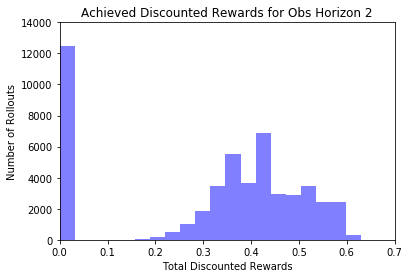

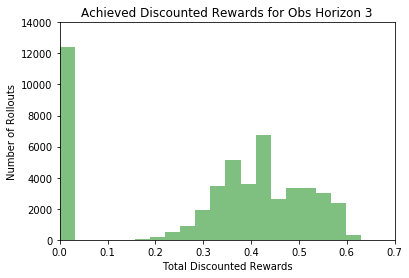

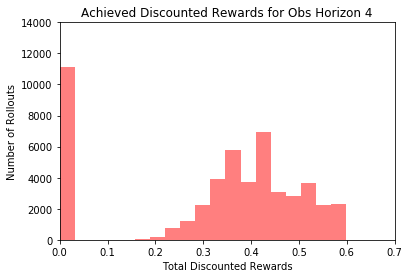

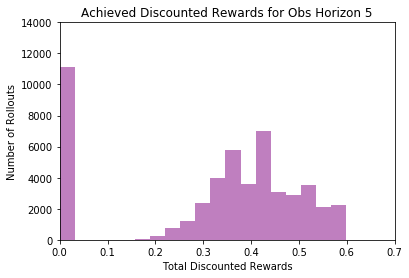

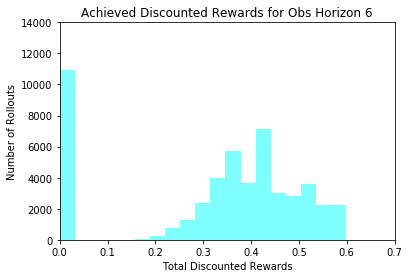

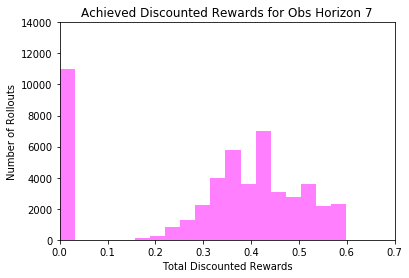

In [279]:
for i in range(len(gw1_noc_tests)):
#     counts,bin_edges = np.histogram(gw1_noc_tests[i], 20)
#     bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
#     plt.scatter(bin_centres, counts, c=colors[i])
    _,_,_ = plt.hist(gw1_noc_tests[i], 20, facecolor=colors[i], alpha=0.5)
    plt.axis([0, 0.7, 0, 14000])
    plt.title("Achieved Discounted Rewards for Obs Horizon {}".format(i+2))
    plt.xlabel("Total Discounted Rewards")
    plt.ylabel("Number of Rollouts")
    plt.show()

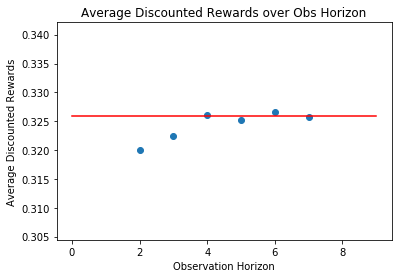

In [281]:
means = [test.mean() for test in gw1_noc_tests]
stds = [test.std() for test in gw1_noc_tests]
plt.scatter(obs_range,means)
max_plite = max([gw1_plite_tests[i].mean() for i in range(len(betas))])
plt.plot(range(10),[max_plite]*10, c='r')
plt.title("Average Discounted Rewards over Obs Horizon".format(i+2))
plt.ylabel("Average Discounted Rewards")
plt.xlabel("Observation Horizon")
plt.show()

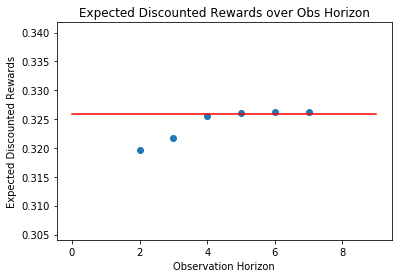

In [283]:
gw1_exp_rews = []
s = grid_game.reset()
for noc in sparse_nocs:
    noc.getFirstAction(s)
    gw1_exp_rews += [noc.values[s]]
plt.scatter(obs_range,gw1_exp_rews)
max_plite = max([gw1_plite_tests[i].mean() for i in range(len(betas))])
plt.plot(range(10),[max_plite]*10, c='r')
plt.title("Expected Discounted Rewards over Obs Horizon")
plt.ylabel("Expected Discounted Rewards")
plt.xlabel("Observation Horizon")
plt.show()
# hist

Compute to value plot

pomdplite roll outs, back up values in tree along observations. Maintain q-value backups, run policy_iter with backups, propagate backups, just stop if values don't change. Do a bunch of roll outs for offline solver

could compare against optimistic Q-value exploration

softmax + eps-greedy on enacting of pomdplite policy for exp

[  3.85626149e-01   4.13435061e-01   4.43522207e-01   4.76070864e-01
   5.11101548e-01   4.76565859e-01   4.90511630e-01   1.33813373e-16
   3.66115980e-01   3.90335302e-01   4.16565686e-01   4.46389007e-01
   4.73699058e-01   4.51104489e-01   4.62242370e-01   4.90511630e-01
   3.45543861e-01   3.62832098e-01   3.51058971e-01  -5.84322713e-16
   4.00116867e-01   4.22164028e-01   4.34879092e-01   4.57571660e-01
   3.25590002e-01   3.37322291e-01   3.22514170e-01   2.49091941e-01
   3.27752553e-01  -1.32386792e-15   4.00583346e-01   4.26309259e-01
   3.06127187e-01   3.11544234e-01   2.74707471e-01   3.28684448e-16
   2.89627944e-01   3.06914527e-01   3.71313630e-01   3.96983240e-01
   2.57079185e-01  -5.21858641e-16   3.65204942e-17   2.19084467e-01
   2.65646429e-01   2.60170186e-01   0.00000000e+00   3.71173041e-01
   2.15889702e-01   7.30409885e-17   1.52385852e-01   1.80980851e-01
  -5.84327908e-16   3.06547572e-01   0.00000000e+00   4.41988950e-01
   1.98826950e-01   1.66970698e-01

/Users/mckane/anaconda2/envs/nrl3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


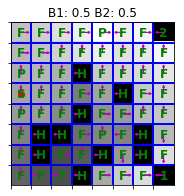

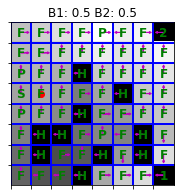

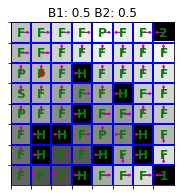

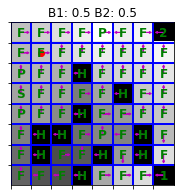

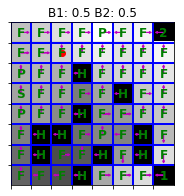

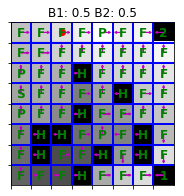

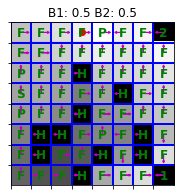

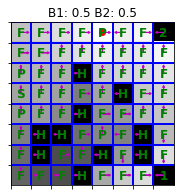

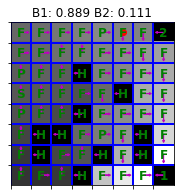

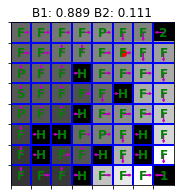

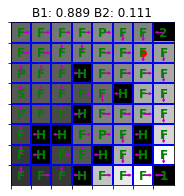

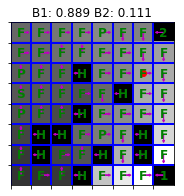

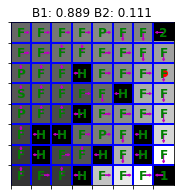

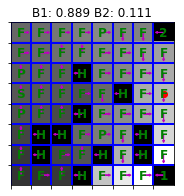

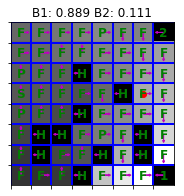

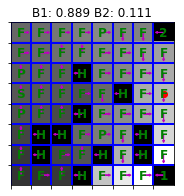

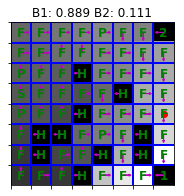

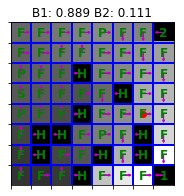

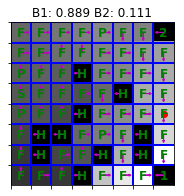

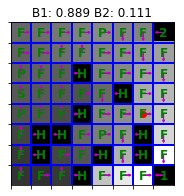

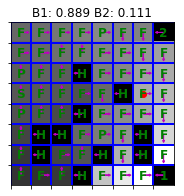

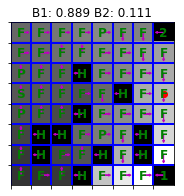

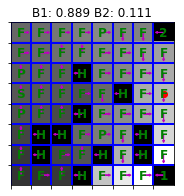

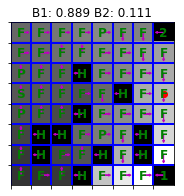

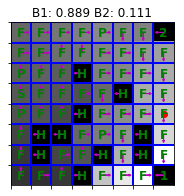

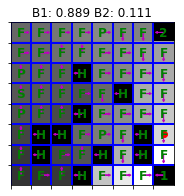

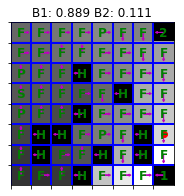

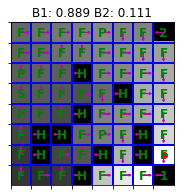

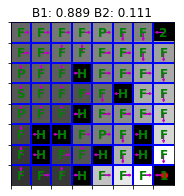

In [160]:
visualize_grid_history(grid_game, run_simulation(approxiNOC,True)[1])

## Experiment 1.2: MultiDiff Gridworld

In [293]:
diffs = np.zeros((64, 4))
diffs[32][3]=1
diffs[44,3]=1

mdp1 = ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.1, rewards=[1,0])#, map_name="4x4_multigoal")
mdp2 = ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.45, rewards=[0,1])#, map_name="4x4_multigoal")
# mdp3 = MDP(ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.4, rewards=[2,0]))#, map_name="4x4_multigoal"))
# true_mdp = ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.1)#, map_name="4x4_multigoal"))

mdp1.seed(0)
mdp2.seed(0)

mdps2 = [mdp1,mdp2]

grid_game2 = NegotiableGame(mdps2,gamma=0.95)

obs_range = range(2,8)
colors = ['blue','green','red','purple','cyan', 'magenta']

In [285]:
sparse_nocs2 = [SparseNocAlg(grid_game2,1000, obs_horizon=i, keep_values=True) for i in obs_range]

In [286]:
n = 50000
gw2_noc_tests = [test(noc,n) for noc in sparse_nocs2]

Mean: 0.29744514175 Std: 0.212190833395
Mean: 0.297711958595 Std: 0.21468424158
Mean: 0.300003437806 Std: 0.209025589319
Mean: 0.302180398258 Std: 0.207187088846
Mean: 0.299357827356 Std: 0.208106268072
Mean: 0.301179301258 Std: 0.207836904295


In [225]:
betas = [0.04,0.05,0.075,0.1,0.15,0.175]
gw2_plite_tests = [test(POMDPlite(grid_game2,1000,beta=i,keep_values=True),5000) for i in betas]

/Users/mckane/CHAI/NRL/pomdplite.py:48: RuntimeWarning: invalid value encountered in true_divide
  divergences = sum([abs(np.nan_to_num(np.divide(belief[i] * Ts[i], joint_T)) - belief[i]) for i in range(len(Ts))])


Mean: 0.271060779417 Std: 0.277285669801
Mean: 0.298017460748 Std: 0.207662710838
Mean: 0.297101455419 Std: 0.195095560497
Mean: 0.296247162253 Std: 0.187046350048
Mean: 0.297766930973 Std: 0.18099519447
Mean: 0.273251217654 Std: 0.16734388851


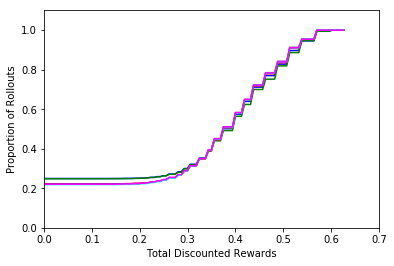

In [304]:
for i in range(len(gw2_noc_tests)):
    counts,bin_edges = np.histogram(gw1_noc_tests[i], 100, density=True)
    counts = [count/sum(counts) for count in counts]
    cdf = [sum(counts[:i]) for i in range(1,len(counts)+1)]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
#     plt.plot(bin_centres, counts, c=colors[i])
    plt.plot(bin_centres, cdf, c=colors[i])

#     _,_,_ = plt.hist(gw2_noc_tests[i], 20, facecolor=colors[i], alpha=0.5)
    plt.axis([0.0, 0.7, 0, 1.1])
#     plt.title("Achieved Discounted Rewards for Obs Horizon {}".format(i+2))
    plt.xlabel("Total Discounted Rewards")
    plt.ylabel("Proportion of Rollouts")
#     plt.show()

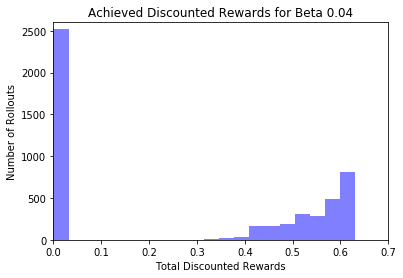

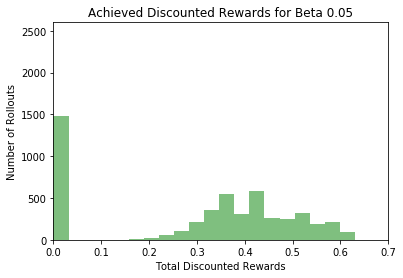

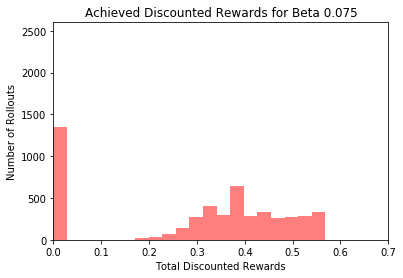

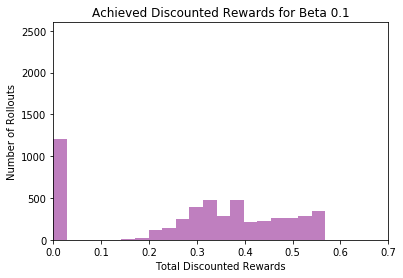

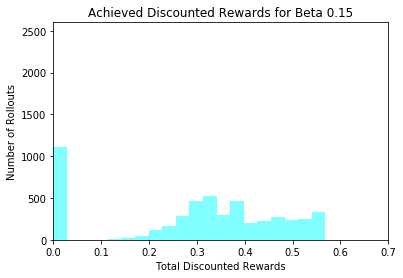

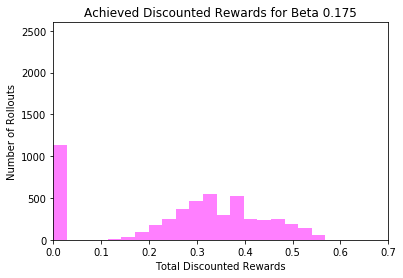

In [230]:
colors = ['blue','green','red','purple','cyan','magenta']
for i in range(len(gw2_plite_tests)):
#     counts,bin_edges = np.histogram(gw1_noc_tests[i], 20)
#     bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
#     plt.scatter(bin_centres, counts, c=colors[i])
    _,_,_ = plt.hist(gw2_plite_tests[i], 20, facecolor=colors[i], alpha=0.5)
    plt.axis([0, 0.7, 0, 2600])
    plt.title("Achieved Discounted Rewards for Beta {}".format(round(betas[i],3)))
    plt.xlabel("Total Discounted Rewards")
    plt.ylabel("Number of Rollouts")
    plt.show()

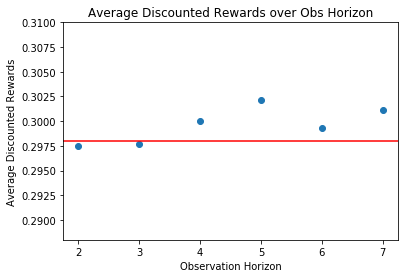

In [306]:
means = [test.mean() for test in gw2_noc_tests]
stds = [test.std() for test in gw2_noc_tests]
plt.scatter(obs_range,means)
max_plite = max([gw2_plite_tests[i].mean() for i in range(len(betas))])
plt.plot(range(10),[max_plite]*10, c='r')
plt.axis([1.75, 7.25, 0.288, 0.31])
plt.title("Average Discounted Rewards over Obs Horizon")
plt.ylabel("Average Discounted Rewards")
plt.xlabel("Observation Horizon")
plt.show()

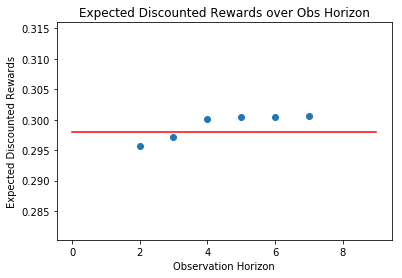

In [308]:
exp_rews = []
s = grid_game2.reset()
for noc in sparse_nocs2:
    noc.getFirstAction(s)
    exp_rews += [noc.values[s]]
plt.scatter(obs_range,exp_rews)
max_plite = max([test.mean() for test in gw2_plite_tests])
plt.plot(range(10),[max_plite]*10, c='r')
plt.title("Expected Discounted Rewards over Obs Horizon")
plt.ylabel("Expected Discounted Rewards")
plt.xlabel("Observation Horizon")
plt.show()

In [207]:
for i in obs_range:
    t = time.time()
    alg = SparseNocAlg(grid_game2,1000, obs_horizon=i, keep_values=True)
    delta = time.time() - t   
    print("Obs Horizon {} took: {}s".format(i,delta))

Obs Horizon 2 took: 0.042938947677612305s
Obs Horizon 3 took: 0.17896795272827148s
Obs Horizon 4 took: 1.0279333591461182s
Obs Horizon 5 took: 6.660320043563843s
Obs Horizon 6 took: 58.38182592391968s
Obs Horizon 7 took: 233.5065610408783s


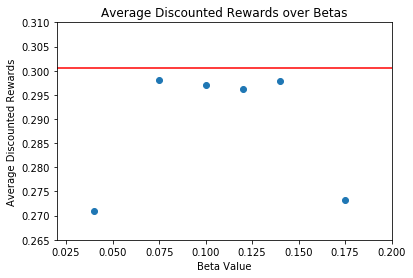

In [315]:
means = [test.mean() for test in gw2_plite_tests]
stds = [test.std() for test in gw2_plite_tests]
plt.scatter(betas,means)
max_noc = exp_rews[-1]
plt.plot(range(10),[max_noc]*10, c='r')
plt.axis([0.02, 0.2, 0.265, 0.31])
plt.title("Average Discounted Rewards over Betas")
plt.ylabel("Average Discounted Rewards")
plt.xlabel("Beta Value")
plt.show()

## Experiment 2: Climate Control

In [13]:
# mdp = ClimateControlEnv(num_rooms=nR, max_steps=50)
# s1 = mdp.temps_to_s((0,0,0))
# s2 = mdp.temps_to_s((1,1,1))

# prefs1 = [(2,10),(2,3),(2,1),(2,1),(2,1),(2,1)]
# prefs2 = [(0,10),(0,1),(1,3),(1,1),(1,1),(0,1)]
# prefs3 = [(0,10),(1,10),(1,1),(1,1),(1,1),(1,1)]
# diffs1 = {(s1,1):[0.05,0.05,0,0.9],(s1,3):[0.05,0.05,0,0.9],
#          (s2,1):[0.05,0.05,0.9,0],(s2,3):[0.05,0.05,0.9,0]}

In [113]:
# mdp1 = ClimateControlEnv(0.0,0.0,prefs1,num_rooms=nR, num_temps=nT, alt_dynamics_probs=diffs1,max_steps=ms)
# mdp2 = ClimateControlEnv(0.0,0.0,prefs2,num_rooms=nR, num_temps=nT, max_steps=ms)
# # mdp3 = ClimateControlEnv(0.0,0.0,prefs3,num_rooms=nR, num_temps=nT,max_steps=ms)
# # true_mdp = ClimateControlEnv(num_rooms=nR, num_temps=nT, max_steps=ms)
# mdp1.seed(0)
# mdp2.seed(0)
# # mdp3.seed(0)

nR = 5
nT = 4
ms = 75
mdps = [ClimateControlEnv(num_rooms=nR, num_temps=nT, sparsity=0.03,max_steps=ms) for _ in range(2)]
for mdp in mdps:
    mdp.seed(0)

gamma = 0.9
climate_game = NegotiableGame(mdps,gamma=gamma)
obs_range = range(2,8)
colors = ['blue','green','red','purple','cyan', 'magenta']

In [93]:
sparse_nocs_clim = [SparseNocAlg(climate_game,ms, obs_horizon=i, keep_values=True) for i in obs_range]

In [94]:
for mdp in mdps:
    print(mdp.prefs)

[(0, 0.08478280435453585), (1, 1.410407650949514), (1, 0.31695061064493973)]
[(0, 2.601509248442067), (2, 3.14911564653219), (0, 1.2978113933295554)]


In [95]:
for alg in sparse_nocs_clim:
    alg.getFirstAction(0)
    print(alg.values)

[ 29.42806991  28.47731464  26.82819531  30.87097901  28.97827014
  28.01876101  31.67766561  30.87997965  28.84142179  28.60326813
  28.16912664  26.63624542  30.30481135  28.72827482  27.33287994
  31.67766561  30.64713392  28.6664239   28.11079486  27.09413734
  25.6626662   29.91409885  27.84918074  26.73307583  31.30984282
  30.17453054  27.9539089 ]
[ 29.43260039  28.48139207  26.83196694  30.87481313  28.98219089
  28.02204175  31.68032     30.88316491  28.84476549  28.60730832
  28.17309376  26.63999222  30.30912259  28.73230292  27.33704301  31.68032
  30.65568039  28.67097388  28.11445607  27.09768824  25.6661594
  29.91768095  27.85298277  26.73744318  31.31249721  30.17983637
  27.95876151]
[ 29.43260039  28.48139207  26.83196694  30.87481313  28.98219089
  28.02204175  31.68032     30.88316491  28.84476549  28.60730832
  28.17309376  26.63999222  30.30912259  28.73230292  27.33704301  31.68032
  30.65568039  28.67097388  28.11445607  27.09768824  25.6661594
  29.91768095  

In [96]:
n = 5000
cc_noc_tests = [test(noc,n) for noc in sparse_nocs_clim]

Mean: 29.6731016654 Std: 24.6517531464
Mean: 29.5971291108 Std: 24.4189763055
Mean: 29.2311106712 Std: 24.3333783383
Mean: 29.5544763037 Std: 24.4195640752
Mean: 29.0488125816 Std: 24.3401088528
Mean: 30.1382765013 Std: 24.3807207188


In [116]:
# pomdplite = POMDPlite(climate_game,ms,beta=37.5)
# test(pomdplite,n)
n = 5
betas = [4]
start = time.time()
cc_plite_tests = [test(POMDPlite(climate_game,ms,beta=i,keep_values=True),n) for i in betas]
end = time.time()
print(end-start)

/Users/mckane/CHAI/NRL/pomdplite.py:48: RuntimeWarning: invalid value encountered in true_divide
  divergences = sum([abs(np.nan_to_num(np.divide(belief[i] * Ts[i], joint_T)) - belief[i]) for i in range(len(Ts))])


Mean: 30.4884539914 Std: 1.41425968271
5.606162071228027


In [68]:
sparse_noc_up_clim = SparseNocAlg(climate_game,ms,updates=True)
cc_noc_up_test = test(sparse_noc_up_clim, 1000)
cc_noc_up_test

Mean: 46.0449645212 Std: 40.7101542961


array([   3.55021208,    4.58566012,    6.35011817,    5.6606803 ,
          6.31228878,    4.70735936,   84.25850016,    4.9718409 ,
          6.17642426,    6.12217167,   86.33725111,   80.90092666,
         86.83224898,    8.29625474,   95.17525572,   81.41475561,
          4.07674089,    6.70349904,   78.77819104,   81.67424629,
          4.50124149,   80.64637815,    5.63801386,   94.04577506,
         84.27495086,    5.25492345,   93.05651347,    6.61142039,
          4.66765539,   86.10322788,   89.38624384,   92.91932336,
         86.37715437,   78.69371641,    6.68137805,    5.68685469,
         94.45794236,    3.9128949 ,    4.13973121,   90.76329869,
         83.57112916,   86.51892739,    6.0245807 ,   87.10995112,
         83.75170936,   88.93616015,    3.66309065,   83.29566938,
         88.61569892,   81.58392265,    5.93078522,    3.93203516,
         81.12748597,    7.17658496,   98.45385819,   88.0706407 ,
         87.95345115,   83.35046645,   87.31975992,   83.71951

/Users/mckane/anaconda2/envs/nrl3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


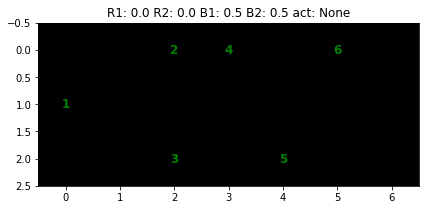

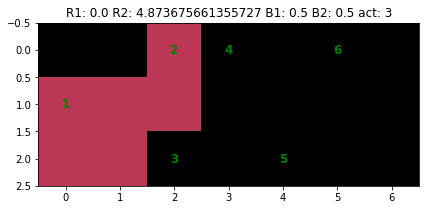

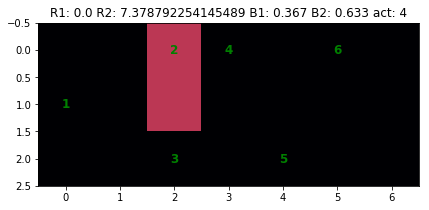

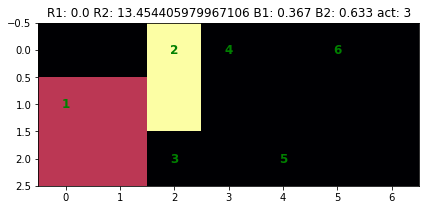

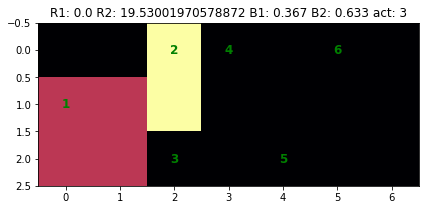

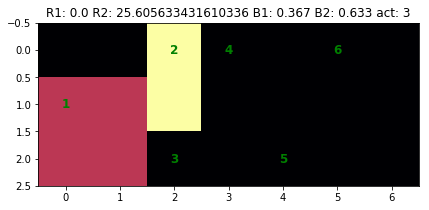

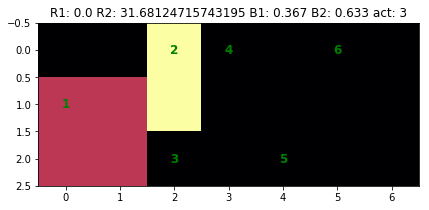

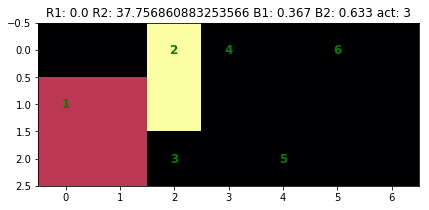

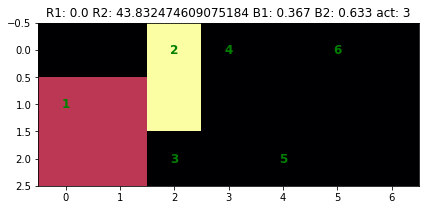

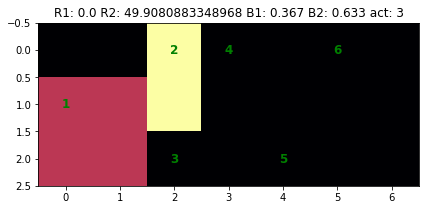

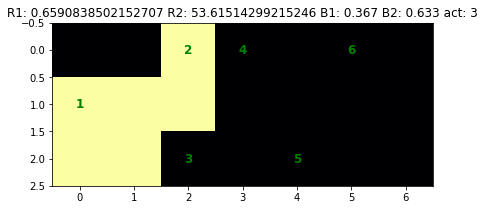

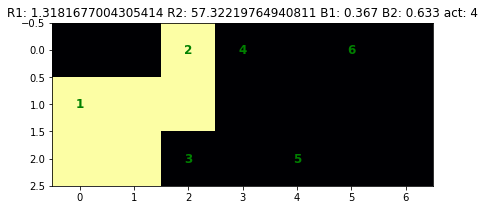

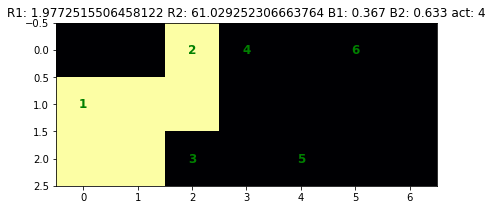

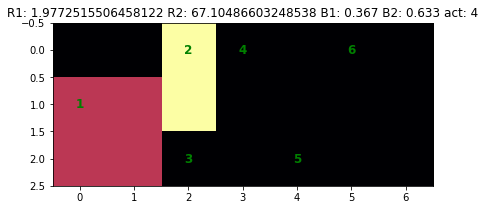

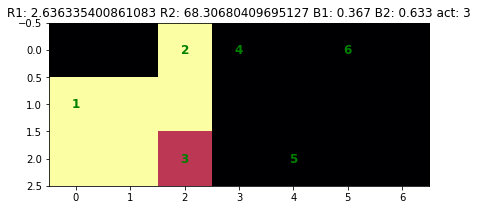

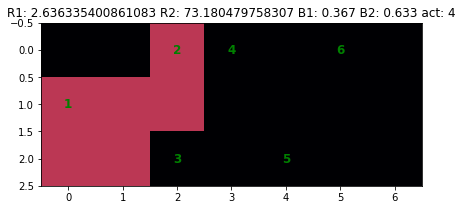

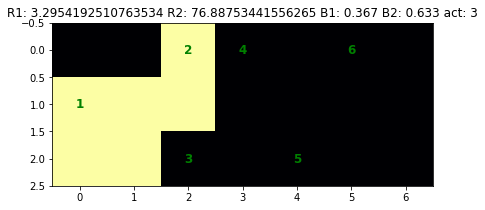

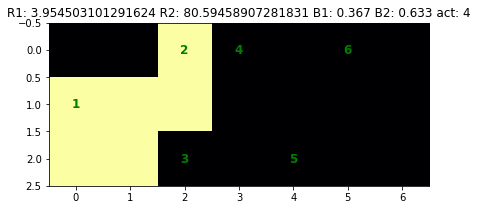

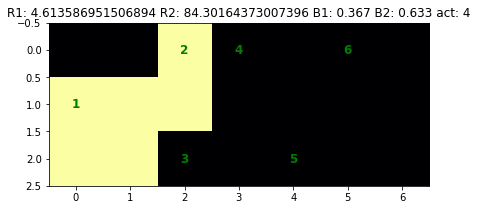

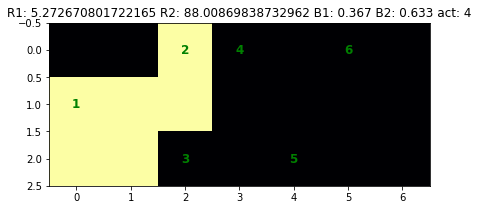

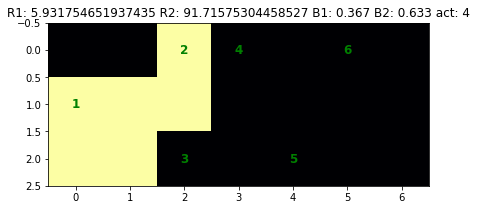

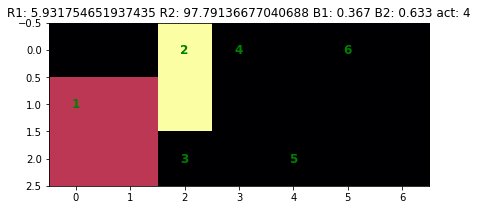

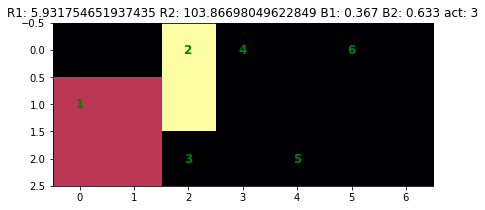

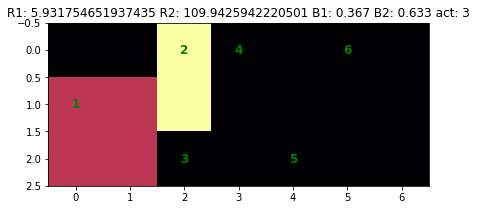

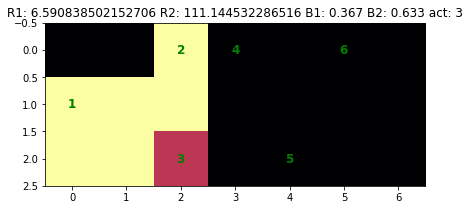

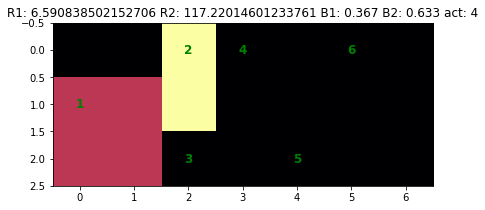

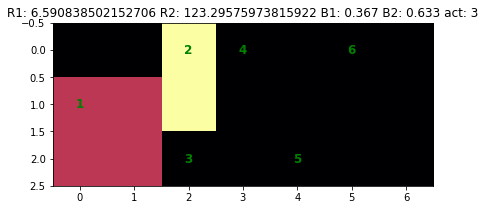

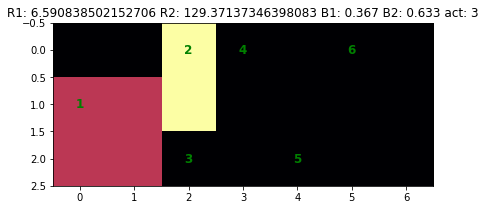

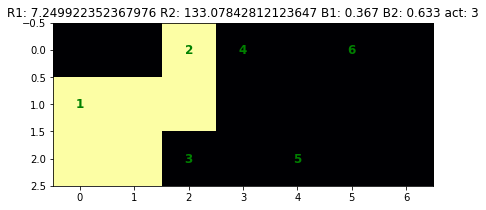

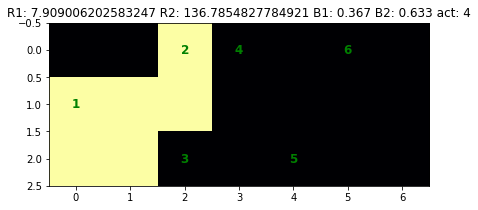

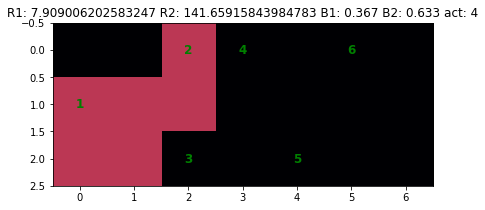

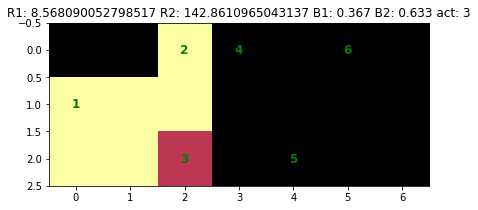

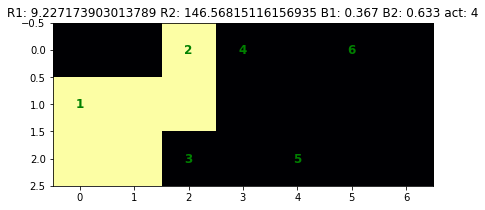

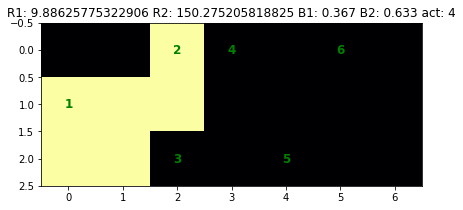

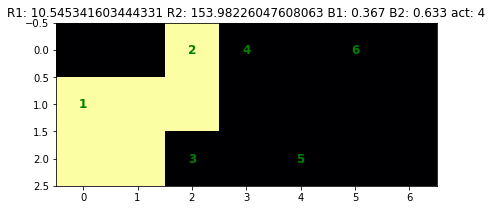

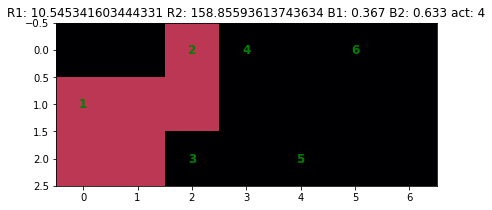

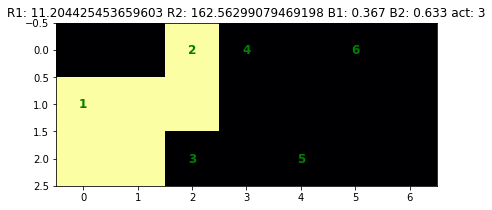

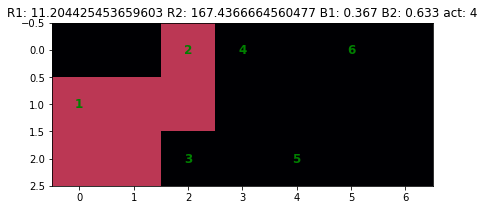

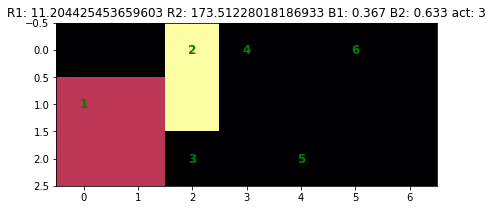

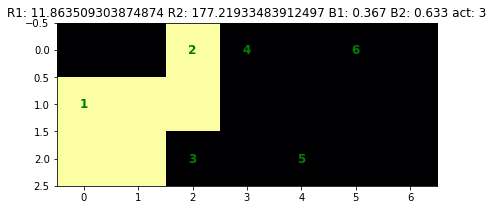

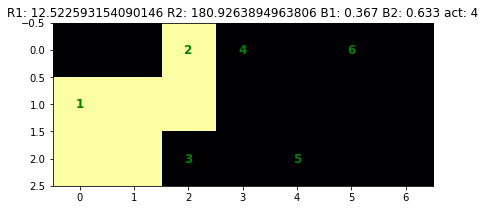

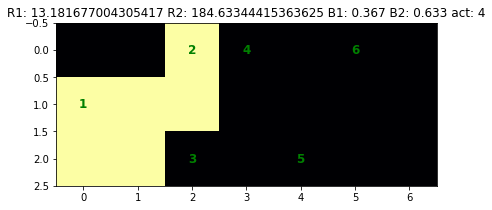

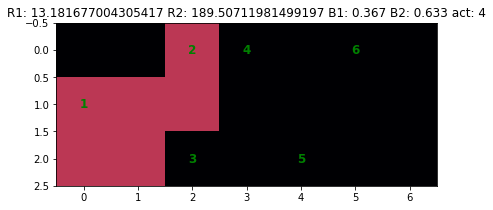

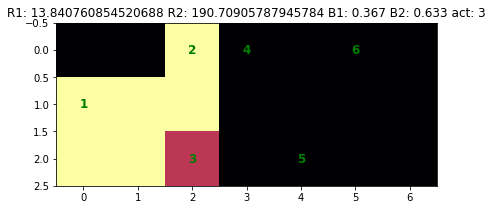

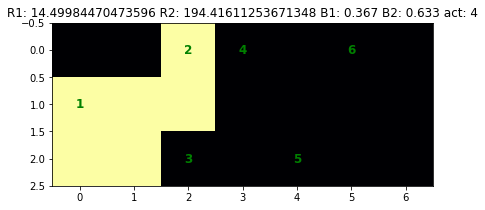

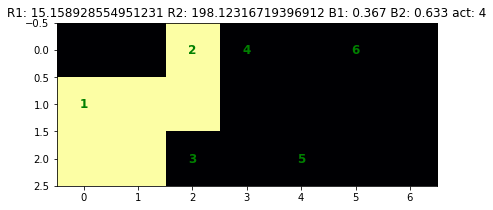

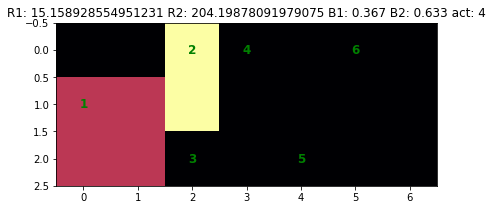

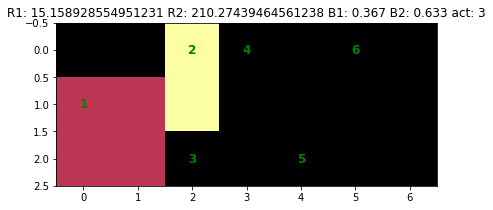

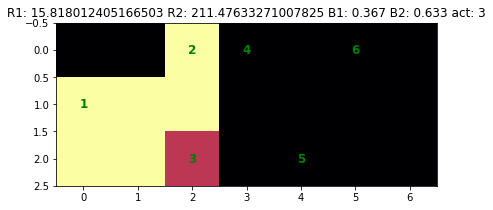

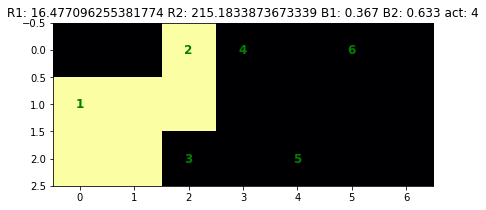

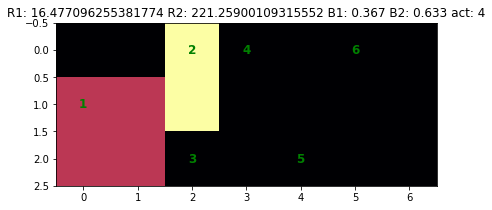

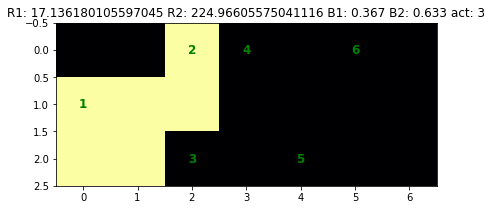

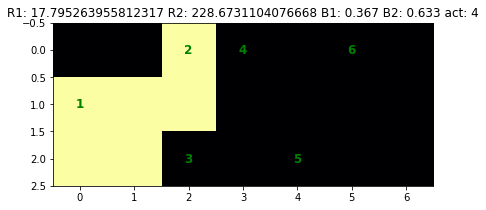

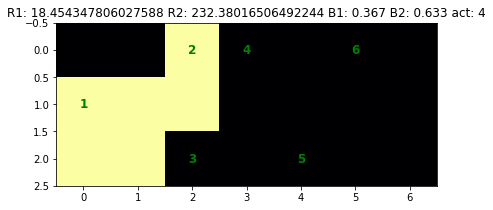

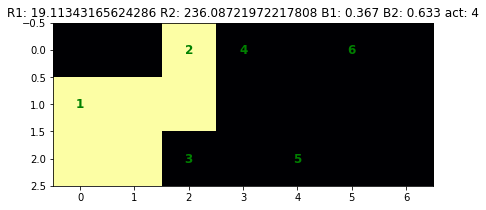

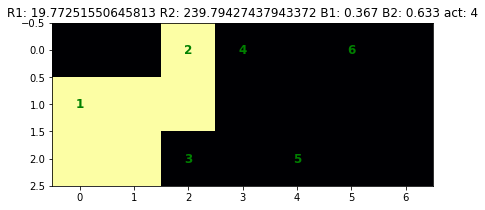

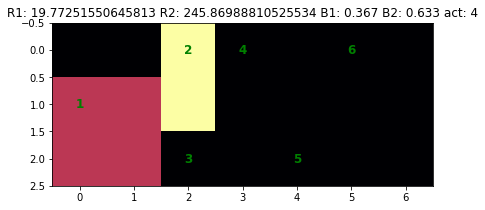

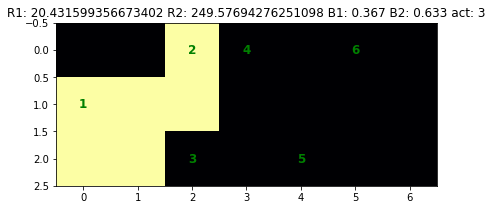

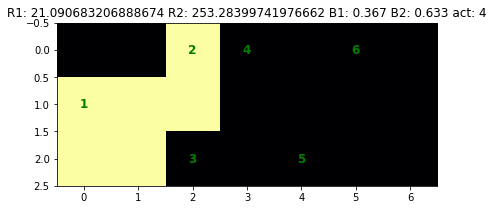

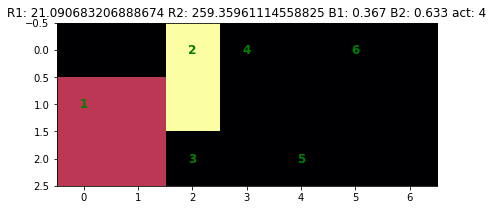

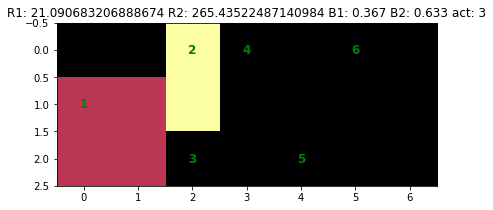

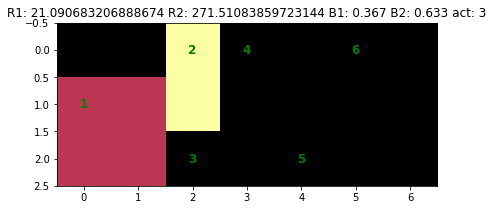

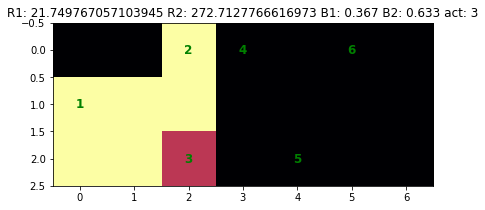

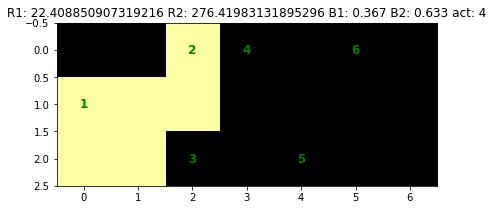

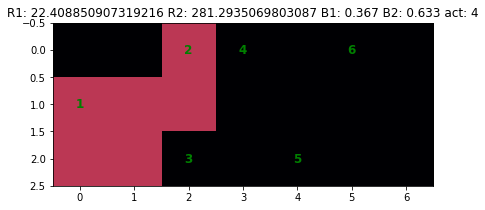

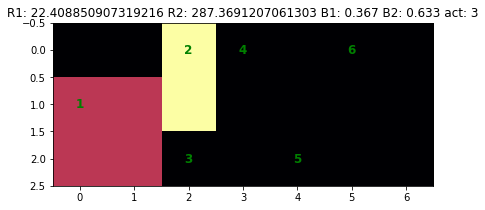

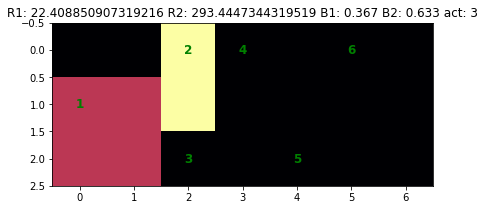

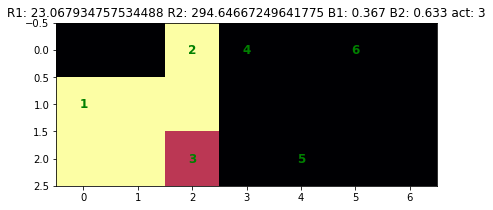

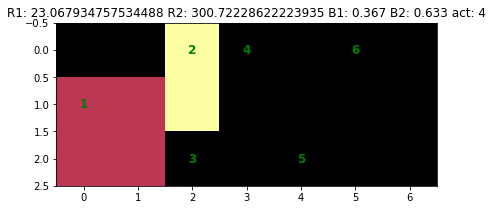

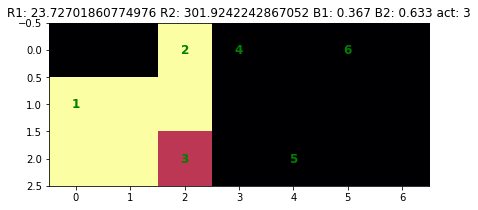

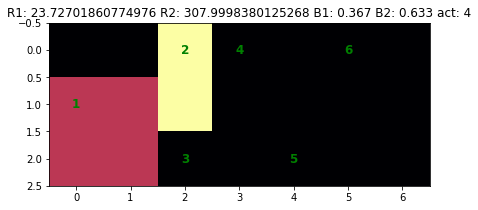

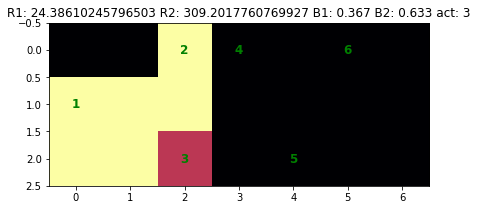

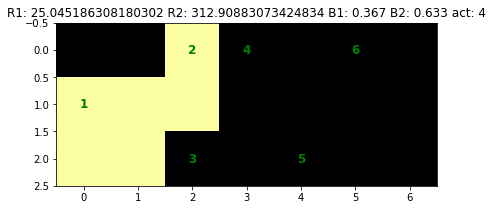

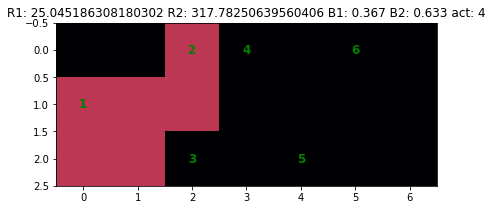

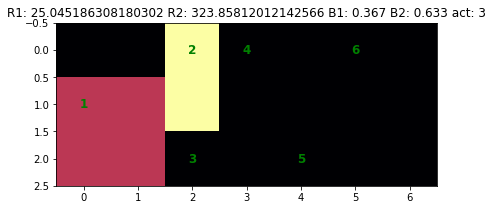

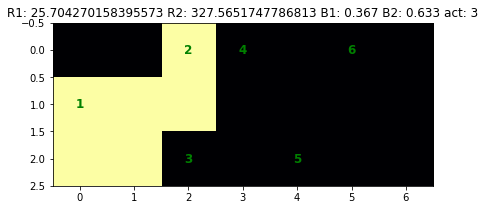

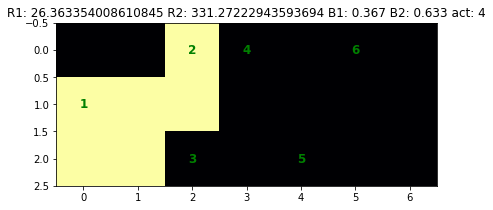

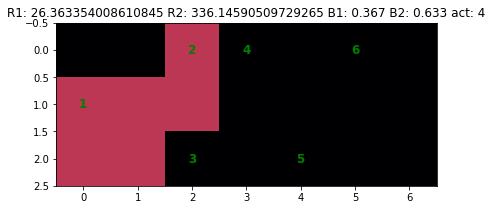

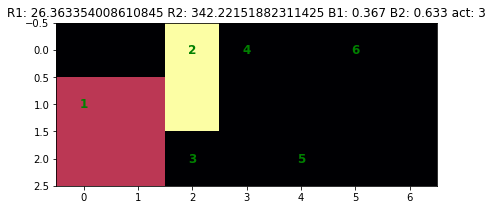

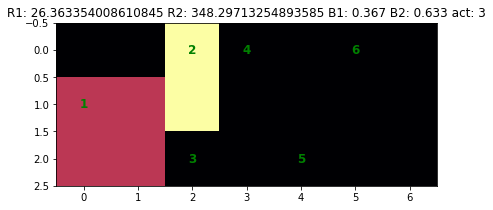

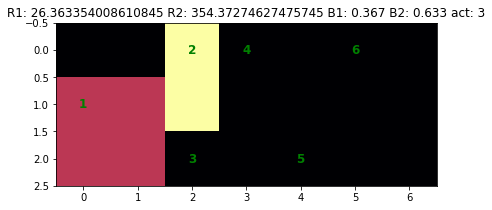

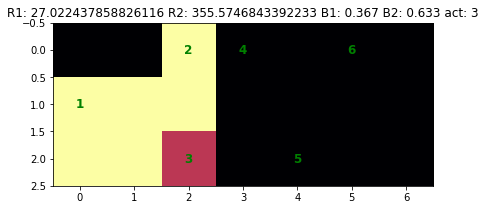

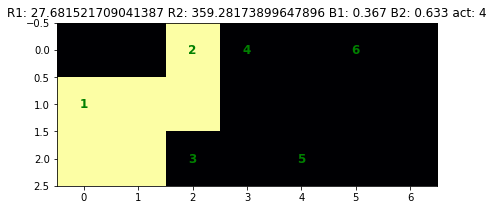

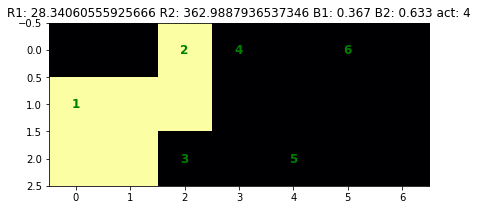

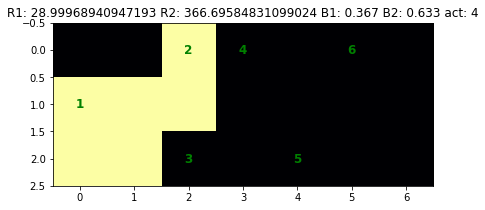

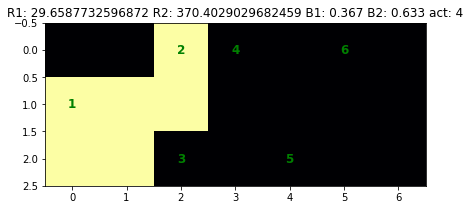

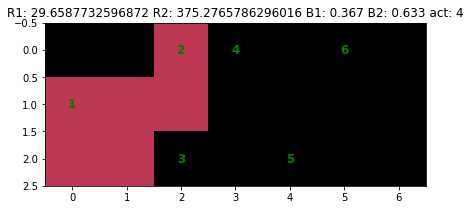

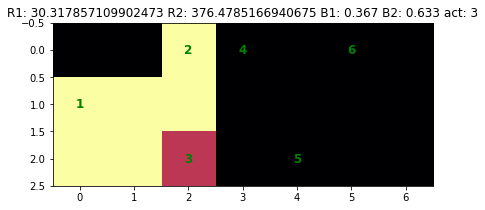

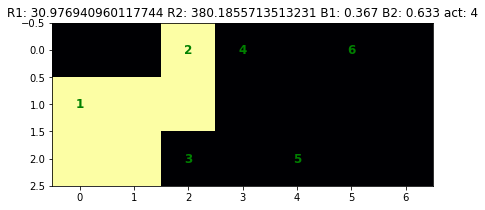

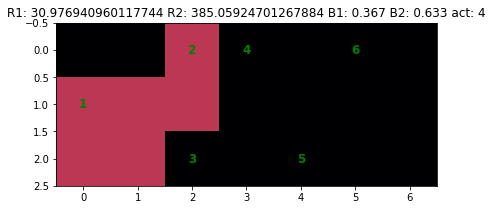

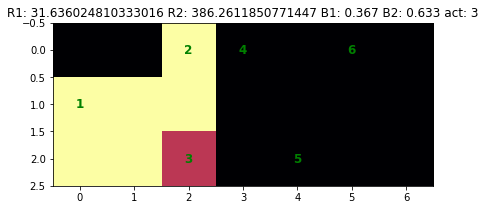

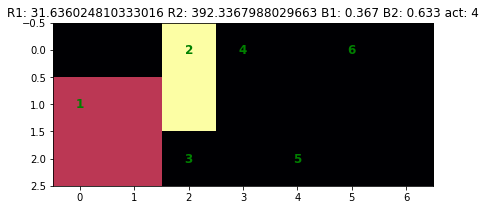

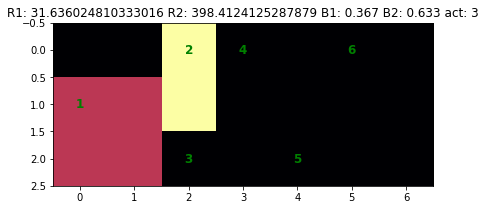

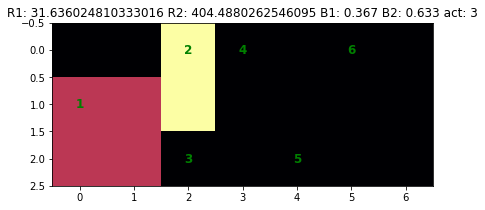

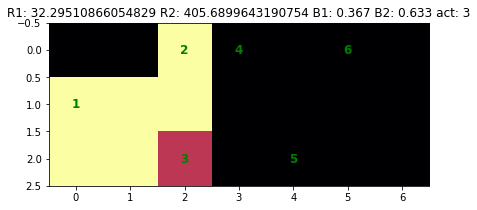

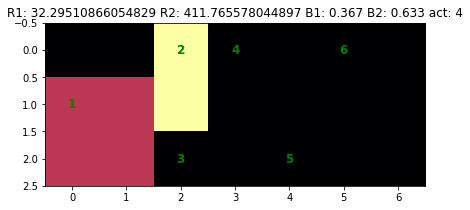

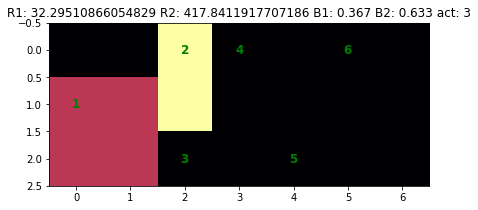

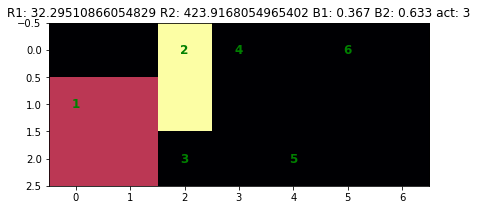

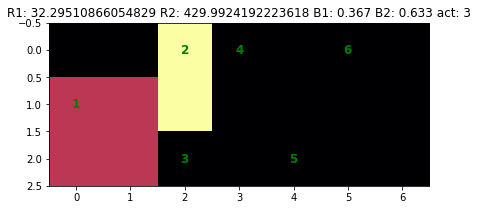

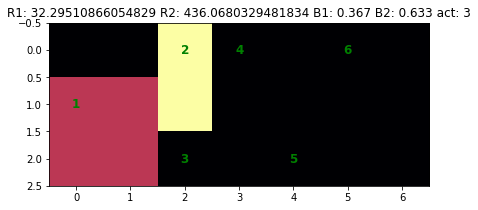

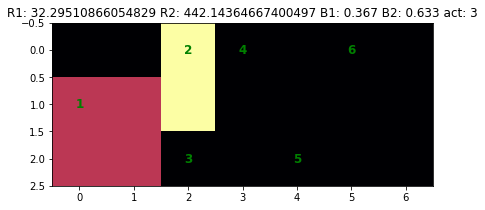

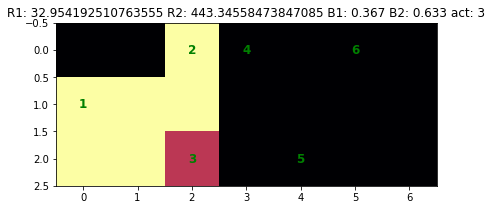

In [59]:
visualize_climate_history(climate_game, run_simulation(sparse_nocs_clim[3],True)[1])

Notes: approxiNOC fares poorly with high gamma, low horizon
good with <2% sparsity and  

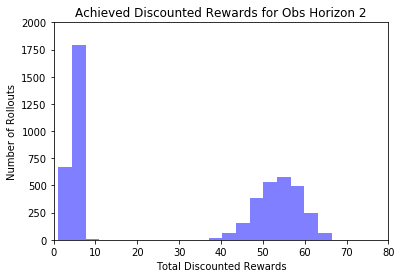

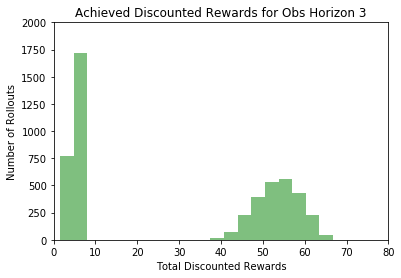

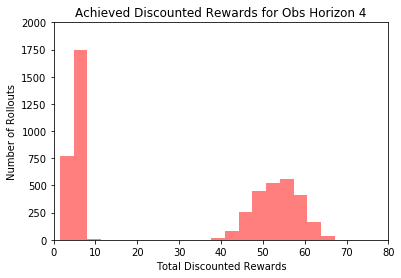

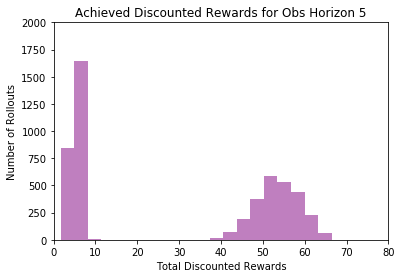

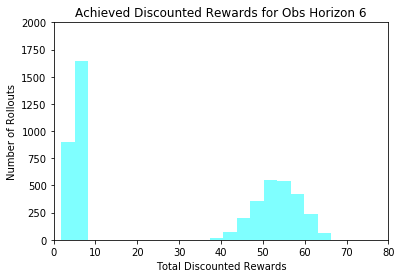

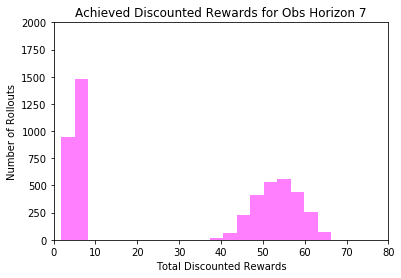

In [99]:
means = [test.mean() for test in cc_noc_tests]
stds = [test.std() for test in cc_noc_tests]
for i in range(len(cc_noc_tests)):
#     counts,bin_edges = np.histogram(gw1_noc_tests[i], 20)
#     bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
#     plt.scatter(bin_centres, counts, c=colors[i])
    _,_,_ = plt.hist(cc_noc_tests[i], 20, facecolor=colors[i], alpha=0.5)
    plt.axis([0, 80, 0, 2000])
    plt.title("Achieved Discounted Rewards for Obs Horizon {}".format(i+2))
    plt.xlabel("Total Discounted Rewards")
    plt.ylabel("Number of Rollouts")
    plt.show()
# plt.axis([0, 0.7, 0, 300])

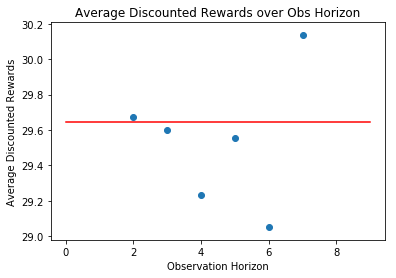

In [108]:
means = [test.mean() for test in cc_noc_tests]
stds = [test.std() for test in cc_noc_tests]

plt.scatter(obs_range,means)
max_plite_error = 0 #((gamma ** ms)/(1-gamma)) * max(sum([pref[1] for pref in mdp.prefs]) for mdp in mdps)
max_plite = max([test.mean() for test in cc_plite_tests]) + max_plite_error
plt.plot(range(10),[max_plite]*10, c='r')
plt.title("Average Discounted Rewards over Obs Horizon")
plt.ylabel("Average Discounted Rewards")
plt.xlabel("Observation Horizon")
plt.show()

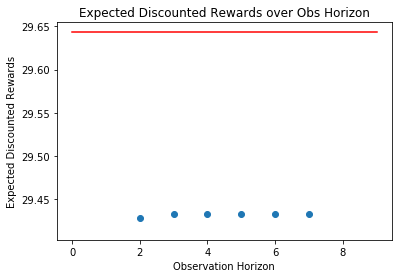

In [109]:
exp_rews = []
s = climate_game.reset()
for noc in sparse_nocs_clim:
    noc.getFirstAction(s)
    exp_rews += [noc.values[s]]
plt.scatter(obs_range,exp_rews)
plt.plot(range(10),[max_plite]*10, c='r')
plt.title("Expected Discounted Rewards over Obs Horizon")
plt.ylabel("Expected Discounted Rewards")
plt.xlabel("Observation Horizon")
plt.show()

In [103]:
exp_rews

[29.428069906171206,
 29.432600385605546,
 29.432600385605532,
 29.432623532583282,
 29.432634506211553,
 29.432640053035904]